# Demo Collab with Bigquery and Google Storage

In [41]:
# Dependencies for training the model
import pandas as pd
from google.cloud import bigquery
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [42]:
# Fetching data with google big query sdk

bq_client = bigquery.Client()
query = "SELECT * FROM `prolaio-data-testing.vpasquierdemo.heart`"
dataset = bq_client.query(query).to_dataframe()
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [43]:
dataset_dummies = pd.get_dummies(
    dataset, columns=["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
)
dataset_dummies.head()

,age,trestbps,chol,thalach,oldpeak,target,sex_0,sex_1,cp_0,cp_1,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,63,145,233,150,2.3,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,37,130,250,187,3.5,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,41,130,204,172,1.4,1,1,0,0,1,...,1,1,0,0,0,0,0,0,1,0
3,56,120,236,178,0.8,1,0,1,0,1,...,1,1,0,0,0,0,0,0,1,0
4,57,120,354,163,0.6,1,1,0,1,0,...,1,1,0,0,0,0,0,0,1,0


In [44]:
standard_scaler = StandardScaler()
columns_to_scale = ["age", "trestbps", "chol", "thalach", "oldpeak"]
dataset_dummies[columns_to_scale] = standard_scaler.fit_transform(
    dataset_dummies[columns_to_scale]
)
dataset_dummies.head()

,age,trestbps,chol,thalach,oldpeak,target,sex_0,sex_1,cp_0,cp_1,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,0.952197,0.763956,-0.256334,0.015443,1.087338,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,-1.915313,-0.092738,0.072199,1.633471,2.122573,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,-1.474158,-0.092738,-0.816773,0.977514,0.310912,1,1,0,0,1,...,1,1,0,0,0,0,0,0,1,0
3,0.180175,-0.663867,-0.198357,1.239897,-0.206705,1,0,1,0,1,...,1,1,0,0,0,0,0,0,1,0
4,0.290464,-0.663867,2.082050,0.583939,-0.379244,1,1,0,1,0,...,1,1,0,0,0,0,0,0,1,0


In [45]:
y = dataset_dummies["target"]
X = dataset_dummies.drop(["target"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Random Forest


In [47]:
rf_param_grid = {"n_estimators": range(1, 100, 10)}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(
    param_distributions=rf_param_grid,
    estimator=rf,
    scoring="accuracy",
    verbose=0,
    n_iter=100,
    cv=4,
)
rf_random.fit(X_train, y_train)
best_params = rf_random.best_params_
print(f"Best parameters: {best_params}")
print(f"Score: {rf_random.score(X_test, y_test)}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'n_estimators': 81}
Score: 0.8688524590163934


<Axes: ylabel='feature'>

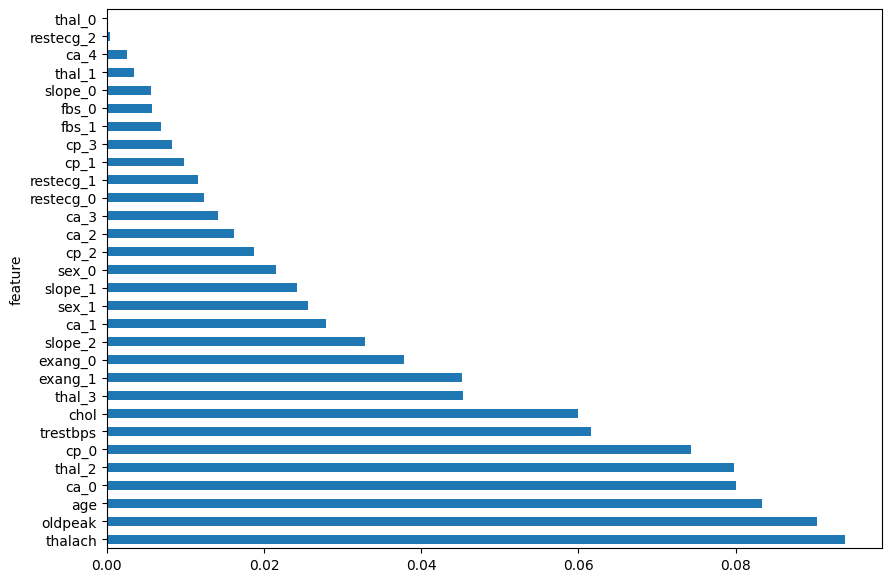

In [48]:
def feature_imp(df, model):
    fi = pd.DataFrame(columns=["feature", "importance"])
    fi["feature"] = df.columns
    fi["importance"] = model.best_estimator_.feature_importances_
    return fi.sort_values(by="importance", ascending=False)

feature_imp(X_train, rf_random).plot(
    "feature", "importance", "barh", figsize=(10, 7), legend=False
)

## ANN

In [49]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Dropout

In [64]:
# conversion for keras
# X_train[X_train.select_dtypes('uint8').columns] = X_train.select_dtypes('uint8').astype('int32')
# X_test[X_test.select_dtypes('uint8').columns] = X_test.select_dtypes('uint8').astype('int32')
X_train = tf.stack(X_train)
X_test = tf.stack(X_test)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
print(y_test.shape)
y_test = y_test[:61]

model = tf.keras.Sequential([
  layers.Dense(20, activation="relu", name="dense1"),
  Dropout(0.2),
  layers.Dense(25, activation="relu", name="dense2"),
  layers.Dense(45, activation="relu", name="dense3"),
  Dropout(0.5),
  layers.Dense(10, activation="relu", name="dense4"),
  layers.Dense(2, activation="sigmoid", name="fc1"),
])

(242,)


In [65]:
model.compile(
  loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=keras.optimizers.Adam(learning_rate = 0.001),
  metrics = ["accuracy"]
)

model.fit(X_train, y_train, batch_size = 32, epochs = 100, verbose=2)
model.evaluate(X_test, y_test, batch_size=32, verbose=2)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8/8 - 1s - loss: 0.7320 - accuracy: 0.4711 - 1s/epoch - 150ms/step
Epoch 2/100
8/8 - 0s - loss: 0.6809 - accuracy: 0.5496 - 23ms/epoch - 3ms/step
Epoch 3/100
8/8 - 0s - loss: 0.6617 - accuracy: 0.6074 - 22ms/epoch - 3ms/step
Epoch 4/100
8/8 - 0s - loss: 0.6428 - accuracy: 0.6033 - 23ms/epoch - 3ms/step
Epoch 5/100
8/8 - 0s - loss: 0.6252 - accuracy: 0.6570 - 21ms/epoch - 3ms/step
Epoch 6/100
8/8 - 0s - loss: 0.5994 - accuracy: 0.7149 - 20ms/epoch - 3ms/step
Epoch 7/100
8/8 - 0s - loss: 0.6265 - accuracy: 0.6488 - 19ms/epoch - 2ms/step
Epoch 8/100
8/8 - 0s - loss: 0.5759 - accuracy: 0.7397 - 22ms/epoch - 3ms/step
Epoch 9/100
8/8 - 0s - loss: 0.5548 - accuracy: 0.7231 - 21ms/epoch - 3ms/step
Epoch 10/100
8/8 - 0s - loss: 0.5338 - accuracy: 0.7397 - 30ms/epoch - 4ms/step
Epoch 11/100
8/8 - 0s - loss: 0.5183 - accuracy: 0.7603 - 24ms/epoch - 3ms/step
Epoch 12/100
8/8 - 0s - loss: 0.4742 - accuracy: 0.7810 - 32ms/epoch - 4ms/step
Epoch 13/100
8/8 - 0s - loss: 0.4840 - accuracy: 0.7893 - 31m

[3.233938694000244, 0.5245901346206665]